In [13]:
#import numpy as np
#import matplotlib as plt


import time
from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram

import qiskit.quantum_info as qi
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.tools.monitor import job_monitor

In [14]:

secret_key='1100'
n=len(secret_key)

In [15]:
q1=QuantumRegister(n+1)
#qc=QuantumCircuit(n+1,n)
qc=QuantumCircuit(q1)
for i in range(n):
    qc.h(i)
qc.x(n)
qc.h(n)
qc.barrier()

#this will be our oracle
for ii, yesno in enumerate(reversed(secret_key)):
    if yesno == '1':
        qc.cx(ii,len(secret_key))
# qc.cx(5,6)
# qc.cx(2,6)
qc.barrier()
for i in range(n):
    qc.h(i)
#qc.measure([0,1,2,3,4,5],[0,1,2,3,4,5])
#qc.measure(range(len(secret_key)),range(len(secret_key)))
#qc.draw(output="mpl")
print(qc)


      ┌───┐      ░            ░ ┌───┐
q2_0: ┤ H ├──────░────────────░─┤ H ├
      ├───┤      ░            ░ ├───┤
q2_1: ┤ H ├──────░────────────░─┤ H ├
      ├───┤      ░            ░ ├───┤
q2_2: ┤ H ├──────░───■────────░─┤ H ├
      ├───┤      ░   │        ░ ├───┤
q2_3: ┤ H ├──────░───┼────■───░─┤ H ├
      ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐ ░ └───┘
q2_4: ┤ X ├┤ H ├─░─┤ X ├┤ X ├─░──────
      └───┘└───┘ ░ └───┘└───┘ ░      


In [16]:
# sim = Aer.get_backend('qasm_simulator')
# result=execute(qc, backend= sim, shots=1).result()
# counts=result.get_counts()
# print(counts)

In [17]:
# Create the expected statevector
q2 = QuantumRegister(4)
bell = QuantumCircuit(q2)
bell.x(3)
bell.x(2)
#bell.h(q2[0])
#bell.cx(q2[0], q2[1])
print(bell)

target_state_bell = qi.Statevector.from_instruction(bell)
print(target_state_bell)

           
q3_0: ─────
           
q3_1: ─────
      ┌───┐
q3_2: ┤ X ├
      ├───┤
q3_3: ┤ X ├
      └───┘
Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2))


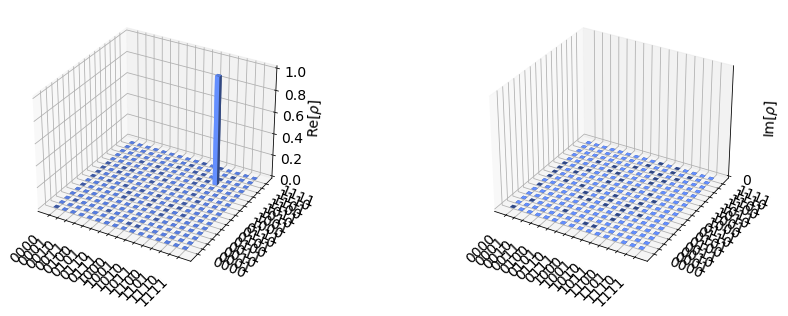

In [18]:
from qiskit.visualization import plot_state_city
plot_state_city(target_state_bell)

In [19]:
#running it on the actual machine
IBMQ.load_account()
# provider=IBMQ.get_provider(hub='ibm-q')
# provider.backend()
# backend = least_busy(filters = lambda x : x.configuration().n_qubits <=7)
# print("least busy backend: ",backend)
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 7 qubits

provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and
                                   x.configuration().n_qubits >= 2 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2022-05-26 15:36:18,218: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_lima


In [20]:
# Generate circuits and run on simulator
t = time.time()

# Generate the state tomography circuits.
qst_bell = state_tomography_circuits(qc, [q1[0], q1[1],q1[2], q1[3]])
#qst_bell = state_tomography_circuits(qc)
# Execute
#job = qiskit.execute(qst_bell, Aer.get_backend('qasm_simulator'), shots=5000)
job = qiskit.execute(qst_bell, backend, shots=5000)
print('Time taken:', time.time() - t)
job_monitor(job, interval = 2)

# Fit result
tomo_fitter_bell = StateTomographyFitter(job.result(), qst_bell)
#job_monitor(job, interval = 2)

Time taken: 7.499972820281982
Job Status: job has successfully run


State Fidelity: F = 0.67365


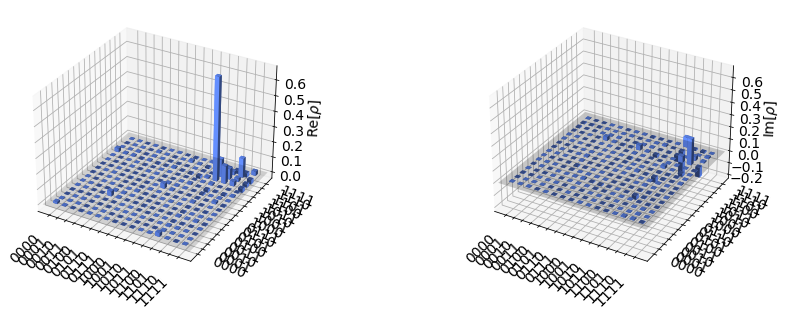

In [21]:
# Perform the tomography fit
# which outputs a density matrix
rho_fit_bell = tomo_fitter_bell.fit(method='lstsq')
F_bell = qi.state_fidelity(rho_fit_bell, target_state_bell)
print('State Fidelity: F = {:.5f}'.format(F_bell))
plot_state_city(rho_fit_bell)